# Convergence along plate boundaries

[WARNING - notebook is still work in progress]

This notebook is an attempt to illustrate the steps involved in determining the convergence velocities along plate boundaries.




In [1]:
import pygplates
import numpy as np


def GetVelocityForPoint(velocity_point,moving_plate,fixed_plate,velocity_type='MagAzim'):
    
    velocity_magnitude = []
    velocity_azimuth = []

    # Get the rotation for current time interval, and the feature's reconstruction plate ID.
    equivalent_stage_rotation = rotation_model.get_rotation(
        time, moving_plate, time+time_step, fixed_plate)

    # Calculate a velocity for each reconstructed point over the 1My time interval.
    velocity_vector = pygplates.calculate_velocities(
        velocity_point,
        equivalent_stage_rotation,
        time_step,
        pygplates.VelocityUnits.cms_per_yr)

    if velocity_type=='north_east':
        velocity = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
            velocity_point,
            velocity_vector)
        if getattr(velocity[0],'get_x',None) is not None:
            pt_vel1 = velocity[0].get_y()
            pt_vel2 = velocity[0].get_x()
        else:
            pt_vel1 = 0.; pt_vel2 = 0.
    else:
        velocity = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
            velocity_point,
            velocity_vector)
        pt_vel1 = velocity[0][0], 
        pt_vel2 = np.degrees(velocity[0][1])

    return time, fixed_plate, moving_plate, pt_vel1, pt_vel2, \
           velocity_point.to_lat_lon()[1], velocity_point.to_lat_lon()[0]
    


# Determine the overriding plate of the subducting line.
def find_overriding_plate(subduction_shared_sub_segment, time):
    
    # Get the subduction polarity of the nearest subducting line.
    subduction_polarity = subduction_shared_sub_segment.get_feature().get_enumeration(pygplates.PropertyName.gpml_subduction_polarity)
    if (not subduction_polarity) or (subduction_polarity == 'Unknown'):
        print('    subduction zone feature is missing subduction polarity property or it is set to "Unknown".')
        return

    overriding_plate = None

    # Iterate over the topologies that are sharing the part (sub-segment) of the subducting line that is closest to the feature.
    sharing_resolved_topologies = subduction_shared_sub_segment.get_sharing_resolved_topologies()
    geometry_reversal_flags = subduction_shared_sub_segment.get_sharing_resolved_topology_geometry_reversal_flags()
    for index in range(len(sharing_resolved_topologies)):

        sharing_resolved_topology = sharing_resolved_topologies[index]
        geometry_reversal_flag = geometry_reversal_flags[index]

        if sharing_resolved_topology.get_resolved_boundary().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
            # The current topology sharing the subducting line has clockwise orientation (when viewed from above the Earth).
            # If the overriding plate is to the 'left' of the subducting line (when following its vertices in order) and
            # the subducting line is reversed when contributing to the topology then that topology is the overriding plate.
            # A similar test applies to the 'right' but with the subducting line not reversed in the topology.
            if ((subduction_polarity == 'Left' and geometry_reversal_flag) or
                (subduction_polarity == 'Right' and not geometry_reversal_flag)):
                overriding_plate = sharing_resolved_topology
                break
        else:
            # The current topology sharing the subducting line has counter-clockwise orientation (when viewed from above the Earth).
            # If the overriding plate is to the 'left' of the subducting line (when following its vertices in order) and
            # the subducting line is not reversed when contributing to the topology then that topology is the overriding plate.
            # A similar test applies to the 'right' but with the subducting line reversed in the topology.
            if ((subduction_polarity == 'Left' and not geometry_reversal_flag) or
                (subduction_polarity == 'Right' and geometry_reversal_flag)):
                overriding_plate = sharing_resolved_topology
                break
    
    if overriding_plate is None:
        print('    topology on overriding side of subducting line is missing.')
        return
    
    return overriding_plate



In [2]:

rotation_filename = '../Data/Seton_etal_ESR2012_2012.1.rot'
input_topology_filename = '../Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'
topology_features = pygplates.FeatureCollection(input_topology_filename)


# Time range and time increment for convergence velocity calculation
time_step = 5.

# Specify time at which to create resolved topological plate polygons
time=0.

###########################################################
rotation_model = pygplates.RotationModel(rotation_filename)

resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

result = []

for shared_boundary_section in shared_boundary_sections:

    # Skip sections that are not ridges or subduction zones.
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            plate_pair = shared_sub_segment.get_sharing_resolved_topologies()

            # If there is a valid plate pair for the segment, continue with calculations
            # If not, there is a topological error, and a message will displayed 
            if len(plate_pair)==2:

                # call the function to determine which plate is the overriding plate
                opid = find_overriding_plate(shared_sub_segment, time)

                if opid is not None:
                    fixed_plate = opid.get_feature().get_reconstruction_plate_id()
                    # the downgoing plate is the other plate in the plate pair
                    if fixed_plate==plate_pair[0].get_feature().get_reconstruction_plate_id():
                        moving_plate = plate_pair[1].get_feature().get_reconstruction_plate_id()
                    else:
                        moving_plate = plate_pair[0].get_feature().get_reconstruction_plate_id()

                    print 'Overriding Plate ID %d' % opid.get_feature().get_reconstruction_plate_id()
                    
                    tesselated_segment = shared_sub_segment.get_geometry().to_tessellated(np.radians(0.25))
                    for point in tesselated_segment:
                        vp = GetVelocityForPoint(point,moving_plate,fixed_plate)
                        result.append(vp)

                else:
                    'Could Not Find Overriding Plate'

            else:
                print 'Bad Shared Topological Section' 

                                

Overriding Plate ID 901
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 301
Overriding Plate ID 224
Overriding Plate ID 224
Overriding Plate ID 224
Overriding Plate ID 224
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 901
Overriding Plate ID 301
Overriding Plate ID 608
Overriding Plate ID 801
Overriding Plate ID 801
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 659
Overriding Plate ID 608
Overriding Plate ID 699
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 801
Overriding Plate ID 801
Overriding Plate ID 697
Overriding Plate ID 901
Overriding Plate ID 824
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 669
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 678
Overriding Plate ID 901
Overriding Plate ID 901
Overriding Plate ID 281
Overriding Plate ID 801
Overriding Plate ID 821
Overriding Plate

(0.0, 901, 801, (2.5077302620557793,), 1.8159303211475464, 160.80192892848, -61.80504124191127)


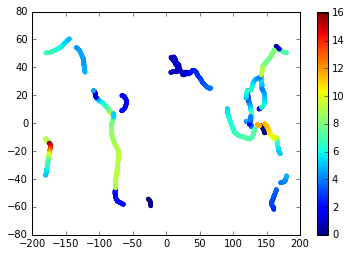

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

print result[0]

plt.scatter(zip(*result)[5],zip(*result)[6],c=zip(*result)[3],edgecolors='')
plt.colorbar()
plt.show()


In [4]:

rotation_filename = '../Data/Seton_etal_ESR2012_2012.1.rot'
input_topology_filename = '../Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'
topology_features = pygplates.FeatureCollection(input_topology_filename)


# Time range and time increment for convergence velocity calculation
time_step = 1.

# Specify time at which to create resolved topological plate polygons
time=0.

###########################################################
rotation_model = pygplates.RotationModel(rotation_filename)

resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

result = []

for shared_boundary_section in shared_boundary_sections:

    # Skip sections that are not ridges or subduction zones.
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            plate_pair = shared_sub_segment.get_sharing_resolved_topologies()

            # If there is a valid plate pair for the segment, continue with calculations
            # If not, there is a topological error, and a message will displayed 
            if len(plate_pair)==2:

                # call the function to determine which plate is the overriding plate
                opid = find_overriding_plate(shared_sub_segment, time)
                
                if opid is not None:

                    fixed_plate = opid.get_feature().get_reconstruction_plate_id()
                    # the downgoing plate is the other plate in the plate pair
                    if fixed_plate==plate_pair[0].get_feature().get_reconstruction_plate_id():
                        moving_plate = plate_pair[1].get_feature().get_reconstruction_plate_id()
                    else:
                        moving_plate = plate_pair[0].get_feature().get_reconstruction_plate_id()

                    print 'Overriding Plate ID %d' % opid.get_feature().get_reconstruction_plate_id()
                    #segments = shared_sub_segment.get_geometry().get_segments()
                    tesselated_segment = shared_sub_segment.get_geometry().to_tessellated(np.radians(0.25))
                    for point in tesselated_segment:
                        #point = segment.get_arc_point(0.5)
                        #print fixed_plate,moving_plate
                        vp = GetVelocityForPoint(point,moving_plate,fixed_plate,
                                                 velocity_type='north_east')
                        result.append(vp)

                else:
                    'Could Not Find Overriding Plate'

            else:
                print 'Bad Shared Topological Section' 

                                

Overriding Plate ID 281
Overriding Plate ID 801
Overriding Plate ID 821
Overriding Plate ID 678
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 678
Overriding Plate ID 901
Overriding Plate ID 901
Overriding Plate ID 697
Overriding Plate ID 901
Overriding Plate ID 824
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 669
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 901
Overriding Plate ID 608
Overriding Plate ID 699
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 801
Overriding Plate ID 801
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 301
Overriding Plate ID 224
Overriding Plate ID 224
Overriding Plate ID 224
Overriding Plate ID 224
Overriding Plate ID 101
Overriding Plate ID 101
Overriding Plate ID 901
Overriding Plate ID 301
Overriding Plate ID 608
Overriding Plate ID 801
Overriding Plate ID 801
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate ID 301
Overriding Plate

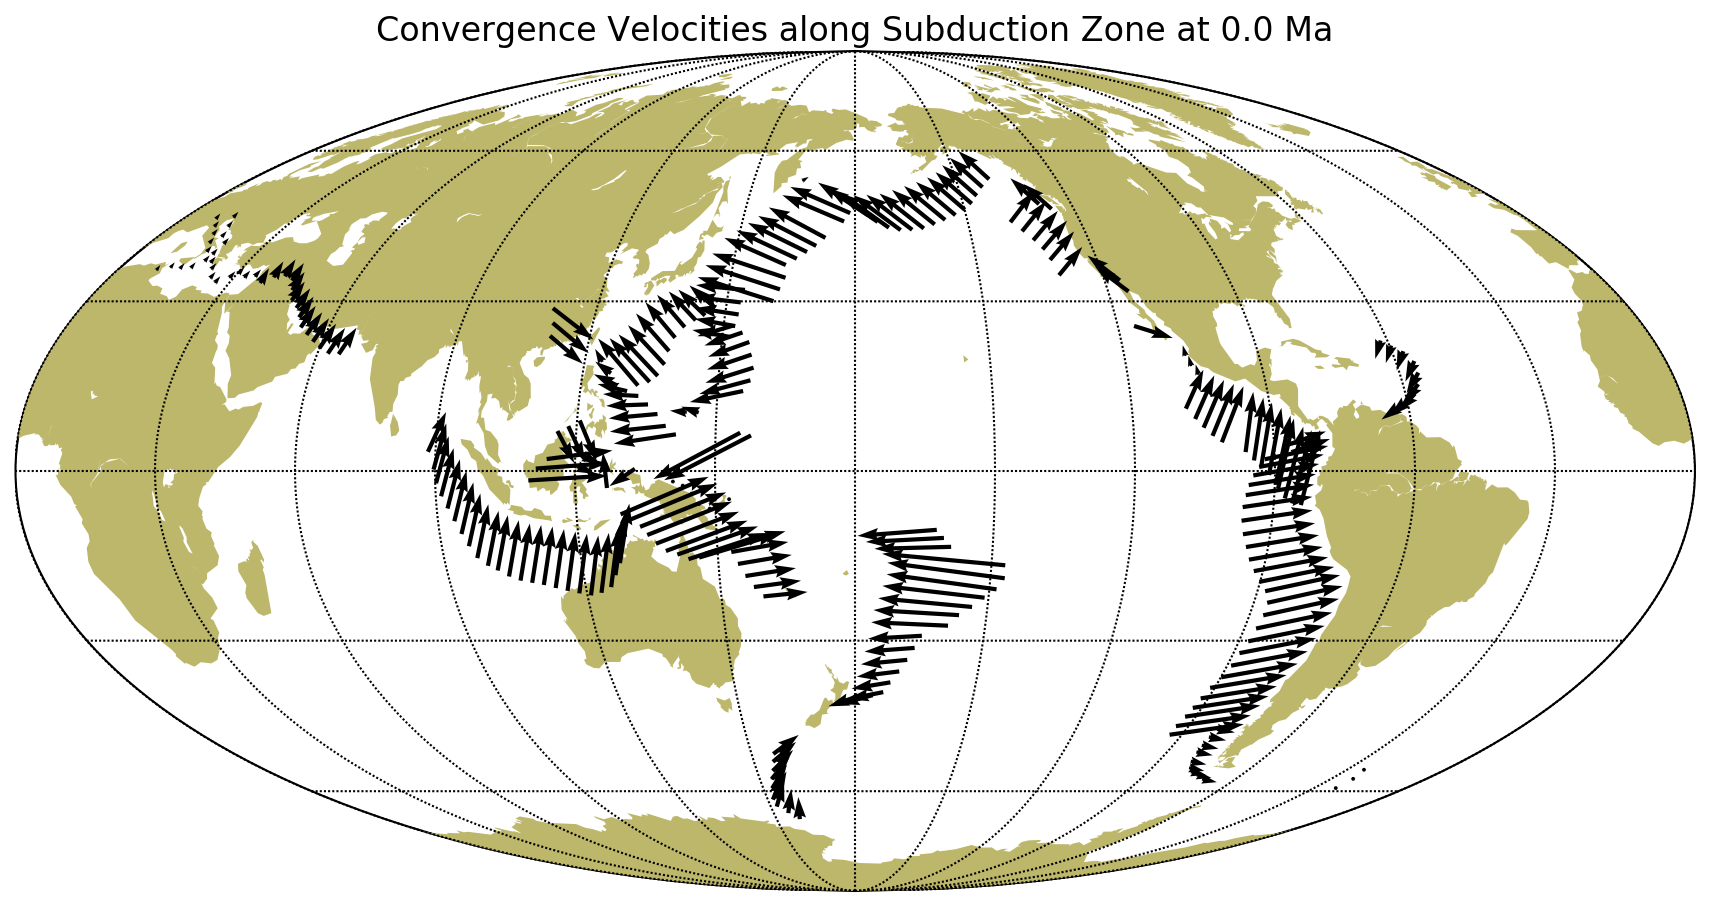

In [5]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])
lon0=180
m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
cp = m.drawmapboundary()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))
m.fillcontinents(color='darkkhaki')

# add the vectors to the map
uproj,vproj,xx,yy = \
m.rotate_vector(np.array(zip(*result)[3]),
                np.array(zip(*result)[4]),
                np.array(zip(*result)[5]),
                np.array(zip(*result)[6]),returnxy=True)
Q = m.quiver(xx[::10],yy[::10],uproj[::10],vproj[::10],
             scale=200,zorder=2,color='k',pivot='tip',
             width=.0025,headlength=5)

plt.title('Convergence Velocities along Subduction Zone at %s Ma' % time, size=16)

plt.show()

